In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.satpos import *

In [2]:
def Log2sta(sol_log):
    # 函数: 将Easy4PPP结果numpy数组转换为定位结果列表
    # function: Transformation between Easy4PPP solution logs to the list of station positions
    # 输入: 结果数组sol_log
    # Input: The numpy array of Easy4PPP solution logs
    # 输出: 定位结果数组[[GPS周, GPS周内秒, 测站ECEF位置X, Y, Z, 测站大地坐标系位置纬度B, 经度L, 椭球高程H]]
    # Output:[[GPS week, GPS second, ECEF-X, ECEF-Y, ECEF-Z, Latitude, Longtitude, Height (Ellipsoidal)]]
    sta=[]
    for i in range(len(sol_log)):
        keys=list(sol_log[i].keys())
        if(not len(keys)):
            continue
        gweek=sol_log[i][keys[0]]['GPSweek']
        gsec=sol_log[i][keys[0]]['GPSsec']
        sta_x=sol_log[i][keys[0]]['sta_x']
        sta_y=sol_log[i][keys[0]]['sta_y']
        sta_z=sol_log[i][keys[0]]['sta_z']
        sta_cdt=sol_log[i][keys[0]]['GPSsec_dt']
        sta_ztd_w=sol_log[i][keys[0]]['ztd_w']
        sta_ztd_h=sol_log[i][keys[0]]['ztd_h']
        sta_b,sta_l,sta_h=xyz2blh(sta_x,sta_y,sta_z)
        sta.append([gweek,gsec,sta_x,sta_y,sta_z,sta_cdt,sta_b,sta_l,sta_h,sta_ztd_w,sta_ztd_h])
    return np.array(sta)

def CRD_SNX2STA(f_name):
    # 函数: 将IGS CRD文件或SNX文件转换为测站基准坐标
    # function: Transformation between IGS SNX or CRD files to the dictionary of station positions
    # 输入: SNX/CRD文件名
    # Input: The path of CRD/SNX file.
    # 输出: 测站基准坐标字典{测站名: [STAX,STAY,STAZ]}
    # Output: {The name of station: [STAX,STAY,STAZ]}
    sta={}
    with open(f_name,"r") as f:
        lines=f.readlines()
        snx_data=[]
        snx_in=0
        now=[0.0,0.0,0.0]
        now_sta="unknown"
        for line in lines:
            if ("+SOLUTION/APRIORI" in line):
                snx_in=1
                continue
            if ("-SOLUTION/APRIORI" in line):
                snx_in=0
                break

            if(snx_in):
                ls=line.split()
                #排除非位置行
                try:
                    int(ls[0])
                except:
                    continue
                #排除未解除的信息行
                if(ls[1] not in ["STAX","STAY","STAZ"]):
                    continue
                #读取固定解位置结果
                if ls[2]!=now_sta:
                    sta[now_sta]=now.copy()
                    now_sta=ls[2]
                    now=[0.0,0.0,0.0]
                now[["STAX","STAY","STAZ"].index(ls[1])]=float(ls[8])
                #print(line.split())
            else:
                continue
    #最后一个测站
    sta[now_sta]=now.copy()
    
    #矫正天线杆臂
    with open( f_name,"r") as f:
        lines=f.readlines()
        snx_in=0
        for line in lines:
            if ("+SITE/ECCENTRICITY" in line):
                snx_in=1
                continue
            if ("-SITE/ECCENTRICITY" in line):
                snx_in=0
                break
            if(snx_in):
                ls=line.split()
                try:
                    xyz0=sta[ls[0]]
                    dneu=[float(ls[-2]),float(ls[-1]),float(ls[-3])]
                    if(dneu[0]==0.0 and dneu[1]==0.0 and dneu[2]==0.0):
                        continue
                    b0,l0,h0=xyz2blh(xyz0[0],xyz0[1],xyz0[2])
                    R=[[-sin(b0/180*pi)*cos(l0/180*pi), -sin(b0/180*pi)*sin(l0/180*pi), cos(b0)],
                        [-sin(l0/180*pi),cos(l0/180*pi),0],
                        [cos(b0/180*pi)*cos(l0/180*pi),cos(b0/180*pi)*sin(l0/180*pi),sin(b0)]]
                    R=np.array(R)
                    R_inv=np.linalg.inv(R)
                    dxyz=(R_inv.dot(np.array(dneu).reshape(3,1))).reshape(3,)
                    xyz0=xyz0+dxyz
                    sta[ls[0]][0]=float(xyz0[0])
                    sta[ls[0]][1]=float(xyz0[1])
                    sta[ls[0]][2]=float(xyz0[2])
                except:
                    pass
                #print(ls)
    #删除无效值
    sta.pop("unknown")
    return sta

First converged in epoch 406


Text(0, 0.5, 'Errors (m)')

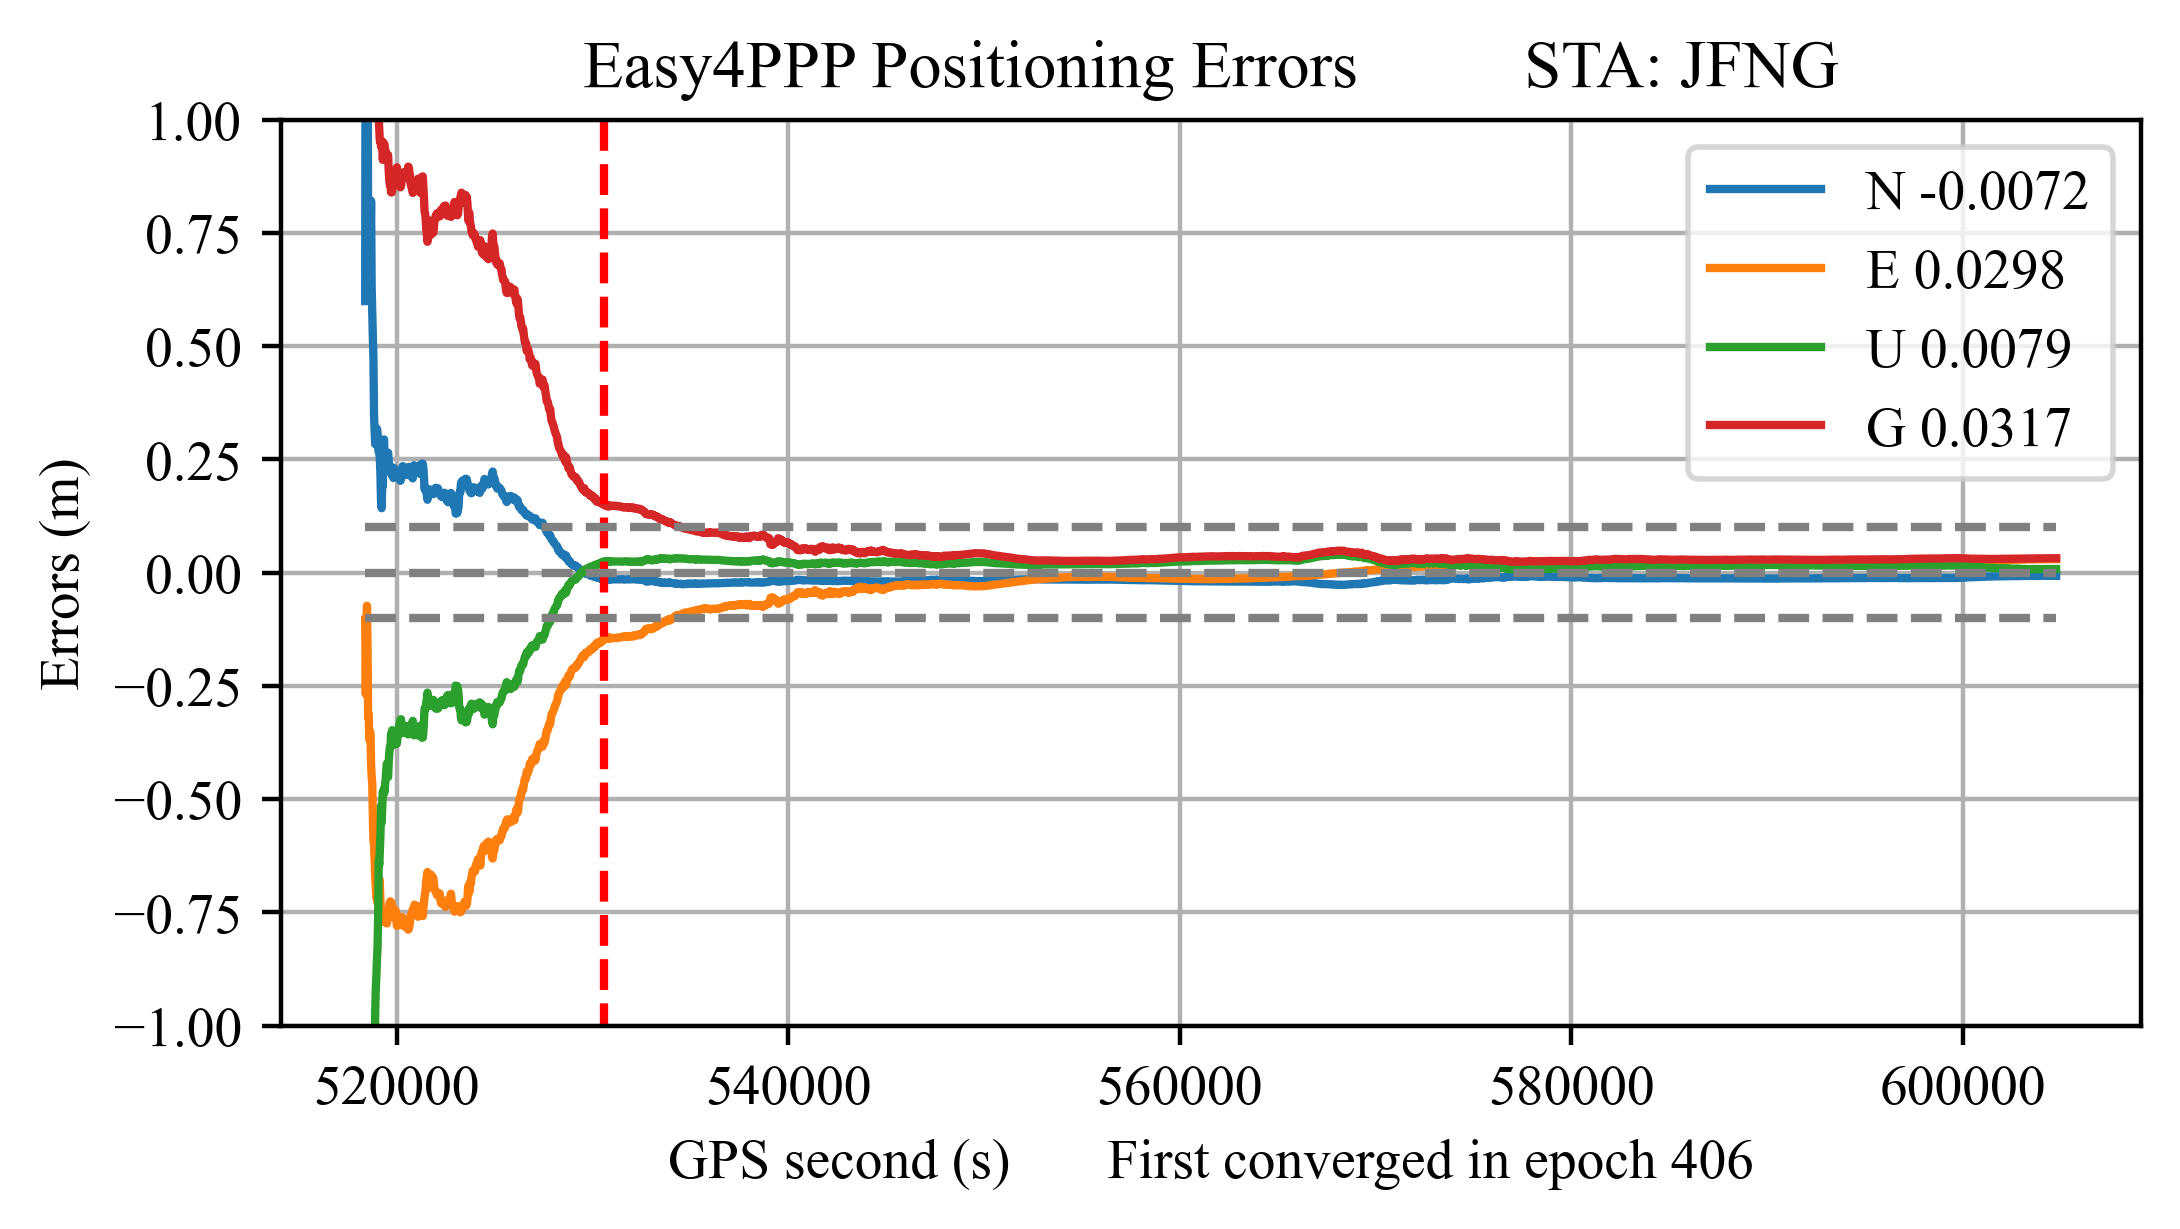

In [3]:
#绘图 PPP误差收敛图
#设置或读取基准坐标ENU误差

#设置Solution logs文件路径
sol_log_f="nav_result/jfng1320.24o.out.npy"
SNX_CRD_f="data/SNX/IGS0OPSSNX_20241320000_01D_01D_CRD.SNX"
STA_name=""                                 #解算站点名称, 若空, 自动赋值为解算日志文件的前四位(依据RINEX V3文件命名规则)
ylim=[-1.0,1.0]                             #误差可视化纵轴范围, 对于PPP而言, ENU误差可视化一般设置为 -1.0m ~ 1.0m 左右较为适宜
STA=[]                                      #解算站点标准位置, 若空, 则由文件读取给出


if(STA_name==""):
    STA_name=sol_log_f.split('/')[-1][:4].upper()

if(STA==[]):
    STA=CRD_SNX2STA(SNX_CRD_f)[STA_name]
sol_log=np.load(sol_log_f,allow_pickle=True)

sta=Log2sta(sol_log)
neu=[]
for x in sta:
    neu_x=xyz2neu([x[2],x[3],x[4]],STA)
    neu_n=np.linalg.norm(xyz2neu([x[2],x[3],x[4]],STA))
    neu.append([x[0],x[1],neu_x[0],neu_x[1],neu_x[2],neu_n])
neu=np.array(neu)

#计算首次收敛时间
fix_epoch='failed'
for i in range(len(neu)):
    if((abs(neu[i][2])<=0.10 and abs(neu[i][3])<=0.10 and abs(neu[i][4])<=0.10) or ((neu[i][5])<=0.15)):
        fix_epoch=i
        break
print("First converged in epoch {}".format(fix_epoch))


#绘图
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.figure(dpi=400,facecolor="white",figsize=(6,3))
plt.plot(neu[:,1],neu[:,2])
plt.plot(neu[:,1],neu[:,3])
plt.plot(neu[:,1],neu[:,4])
plt.plot(neu[:,1],neu[:,5])
plt.grid('on')
plt.legend(["N {:.4f}".format(np.mean(neu[-1,2])),"E {:.4f}".format(np.mean(neu[-1,3])),"U {:.4f}".format(np.mean(neu[-1,4])),"G {:.4f}".format(np.mean(neu[-1,5]))])

#绘制收敛点
if(fix_epoch!="failed"):
    plt.plot([neu[fix_epoch][1],neu[fix_epoch][1]],[1.0,-1.0],'--',c="red")

#收敛标准线(-0.1m, 0.1m)
plt.plot([sta[0][1],sta[-1][1]],[0.0,0.0],'--',c='grey')
plt.plot([sta[0][1],sta[-1][1]],[0.1,0.1],'--',c='grey')
plt.plot([sta[0][1],sta[-1][1]],[-0.1,-0.1],'--',c='grey')

if(ylim!=[]):
    plt.ylim(ylim[0],ylim[1])

plt.title("Easy4PPP Positioning Errors          STA: {}".format(STA_name))
plt.xlabel("GPS second (s)       First converged in epoch {}".format(fix_epoch))
plt.ylabel("Errors (m)")

Text(0.5, 1.0, 'Easy4PPP Reciver Clock Bias          STA:JFNG')

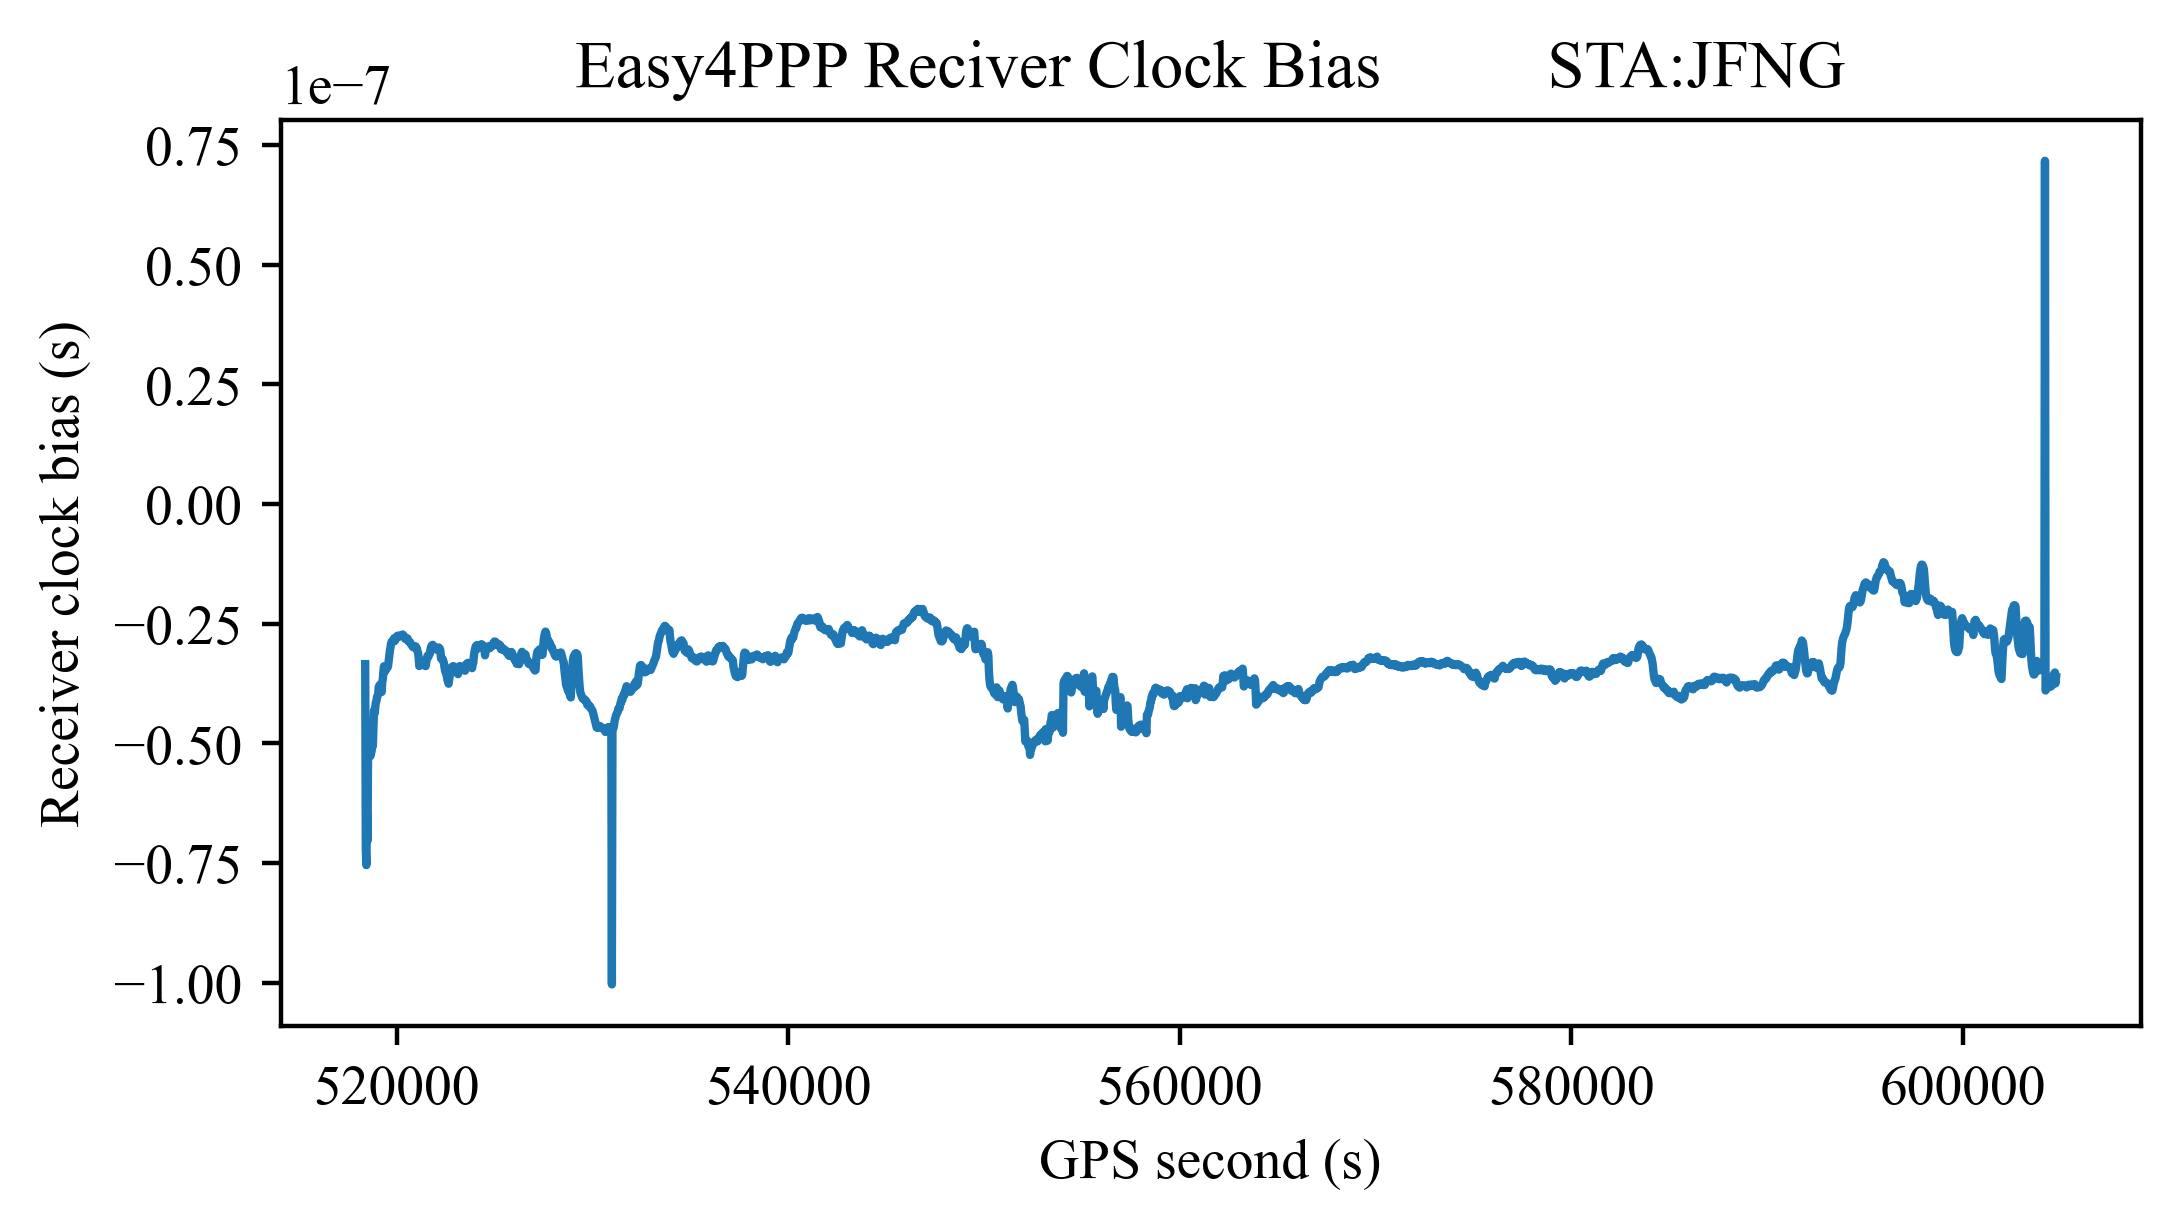

In [4]:
# 绘图: 接收机钟差
show_mode="s"           #设置钟差显示模式: s: 以秒为单位; m: 以m为单位

sta=Log2sta(sol_log)
plt.figure(dpi=400,facecolor="white",figsize=(6,3))
if(show_mode=="m"):
    plt.plot(sta[:,1],sta[:,5])
if(show_mode=="s"):
    plt.plot(sta[:,1],sta[:,5]/clight)

plt.xlabel("GPS second (s)")
plt.ylabel("Receiver clock bias ({})".format(show_mode))

plt.title("Easy4PPP Reciver Clock Bias          STA:{}".format(STA_name))

Text(0.5, 1.0, 'Easy4PPP Zenith Tropospheric Delay          STA:JFNG')

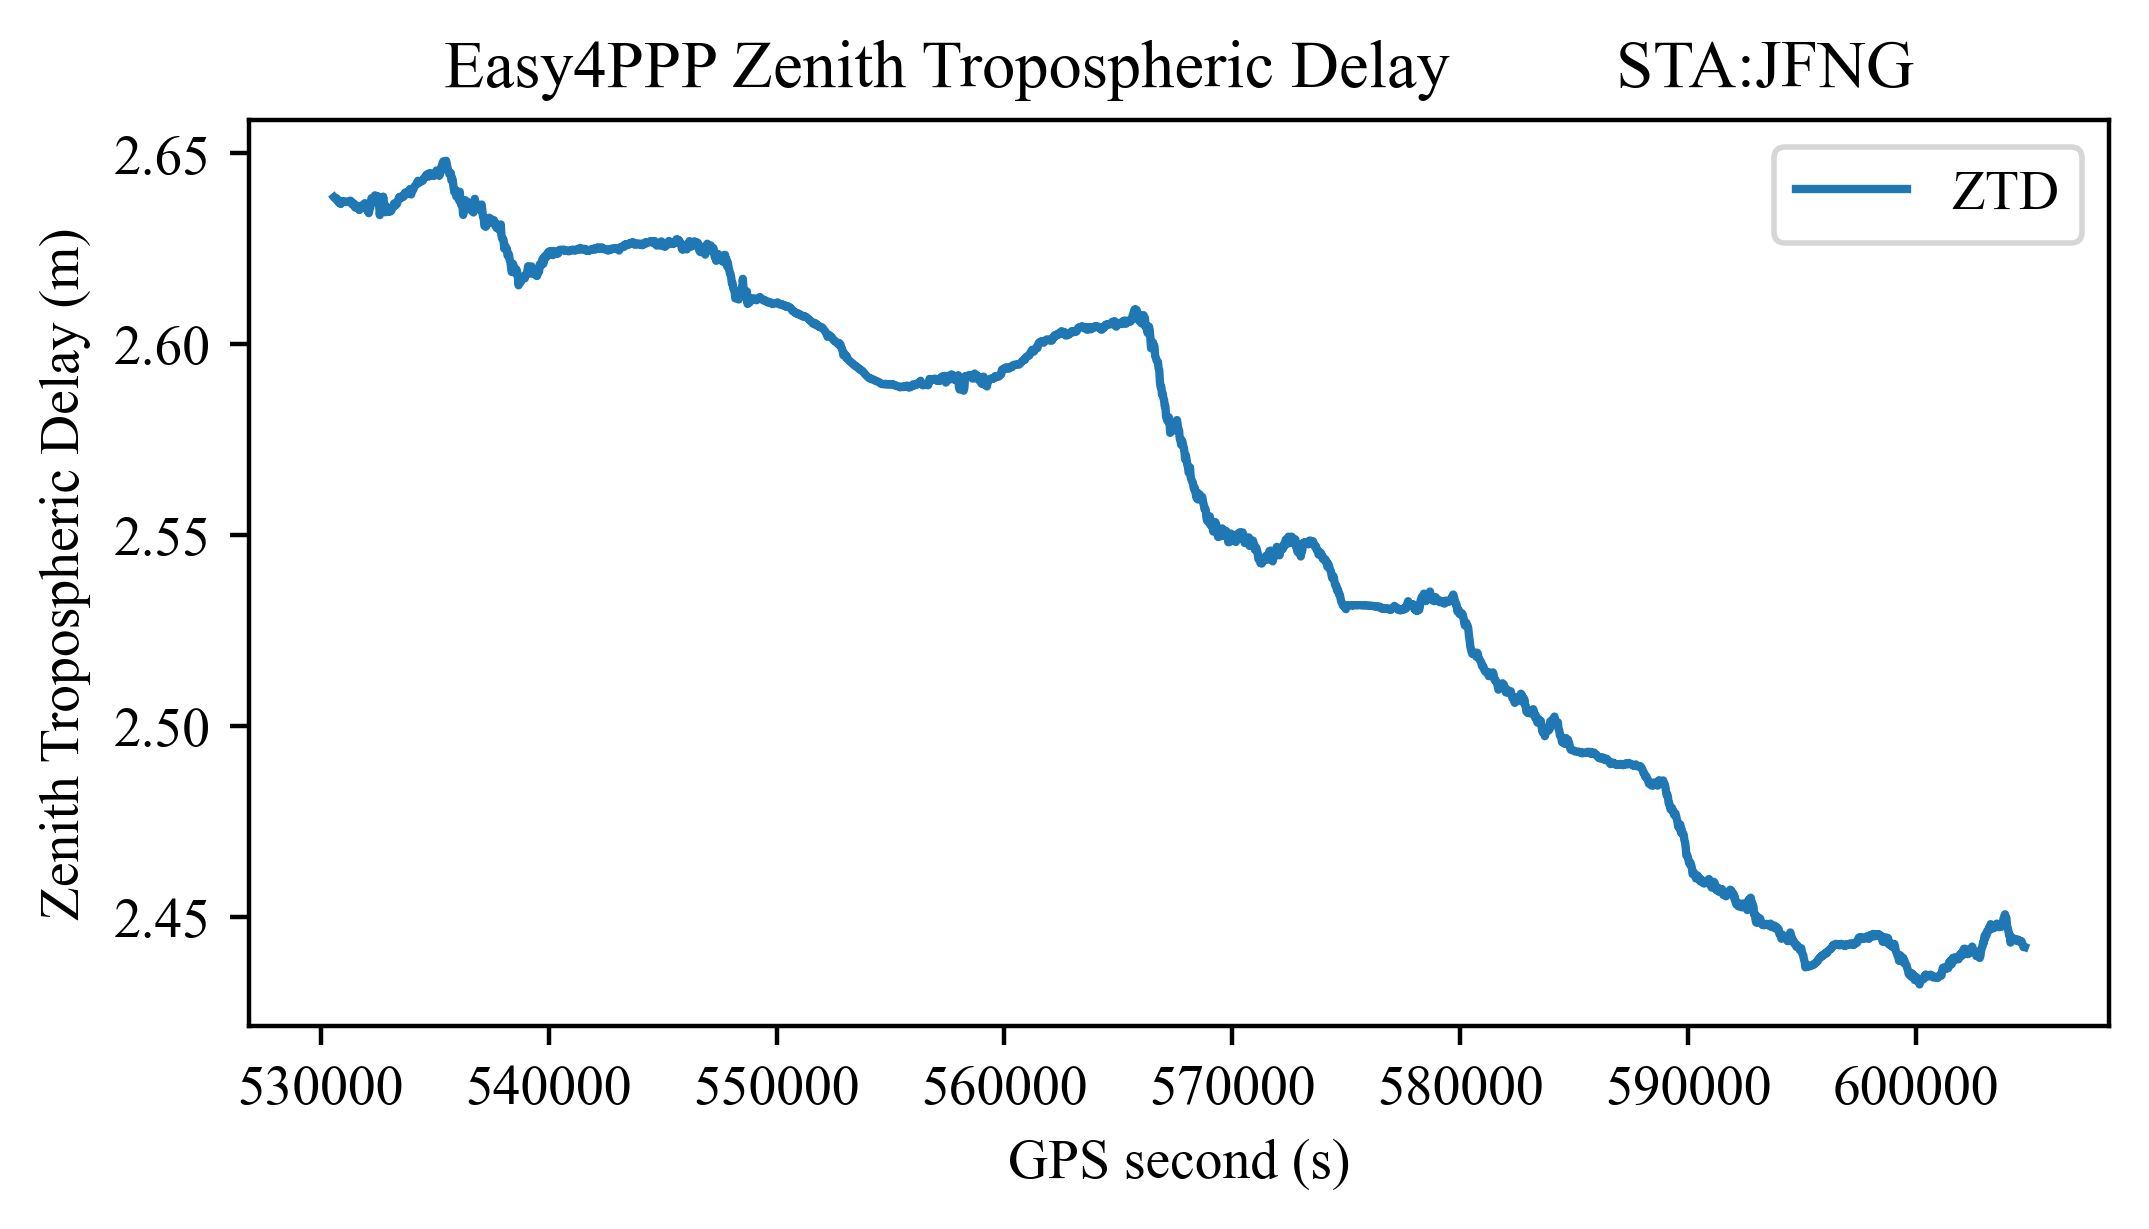

In [5]:
# 绘图: 天顶对流层延迟
show=["ZTD"]    #设置大气延迟产品级别, "ZTD-W":湿延迟; "ZTD-H":干延迟; "ZTD": 总延迟

legend=[]
sta=Log2sta(sol_log)
plt.figure(dpi=400,facecolor="white",figsize=(6,3))
if("ZTD-W" in show):
    plt.plot(sta[fix_epoch:,1],sta[fix_epoch:,9])                   #本示例大气延迟产品从几何位置收敛开始取用
    legend.append("ZTD-W")
if("ZTD-H" in show):
    plt.plot(sta[fix_epoch:,1],sta[fix_epoch:,10])
    legend.append("ZTD-H")
if("ZTD" in show):
    plt.plot(sta[fix_epoch:,1],sta[fix_epoch:,9]+sta[fix_epoch:,10])
    legend.append("ZTD")
plt.legend(legend)

plt.xlabel("GPS second (s)")
plt.ylabel("Zenith Tropospheric Delay (m)")

plt.title("Easy4PPP Zenith Tropospheric Delay          STA:{}".format(STA_name))

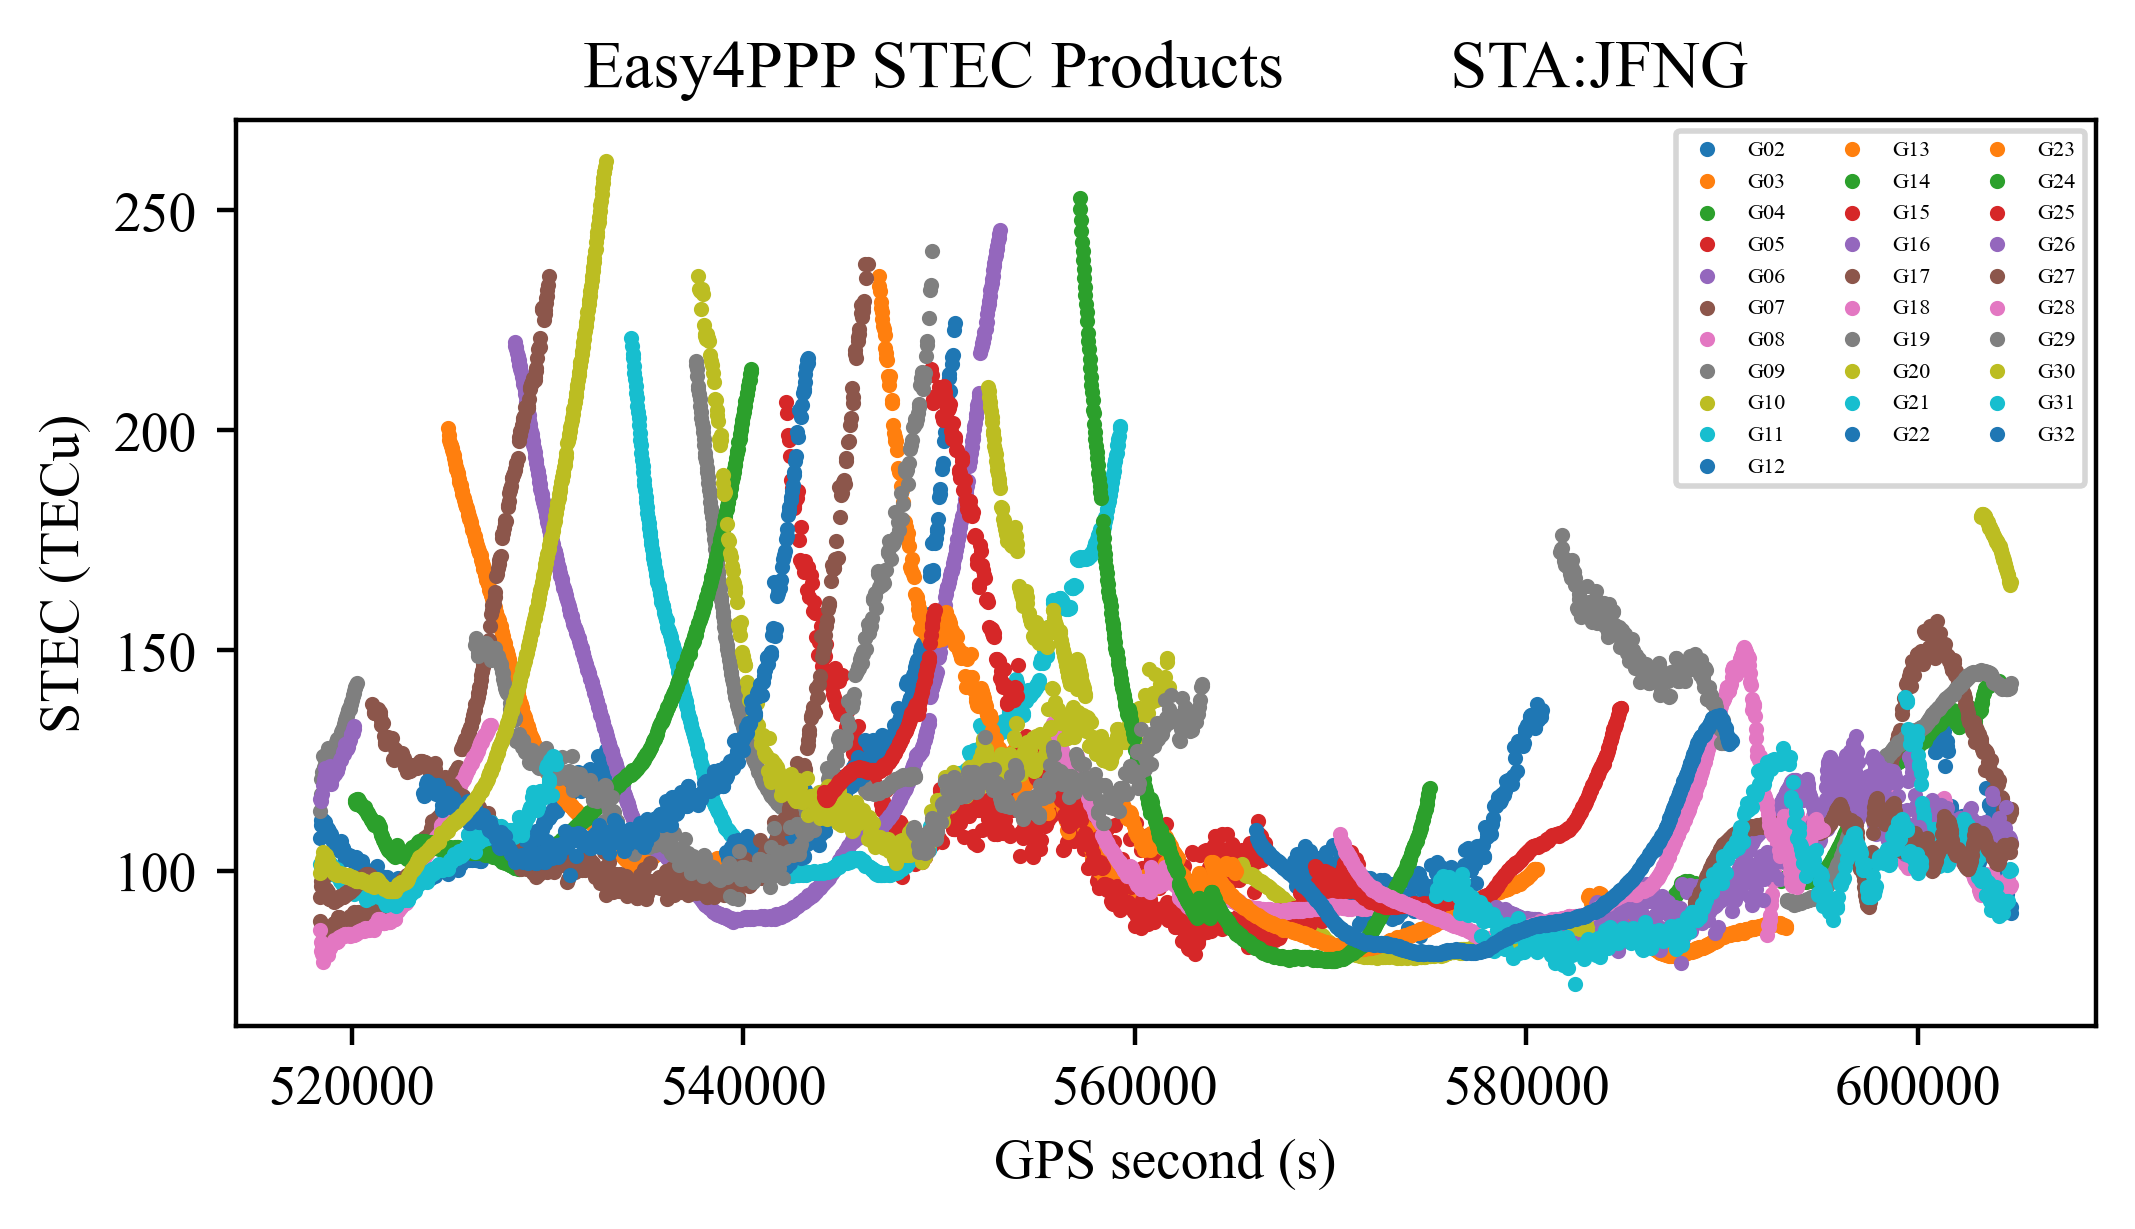

In [6]:
#绘图: 测站STEC数据
import matplotlib.pyplot as plt
sys_sat_num=65
sys_name='G'
P_threshold=99999.0

plt.figure(dpi=400,facecolor="white",figsize=(6,3))
legend=[]
for PRN in range(1,sys_sat_num+1):
    PRN=sys_name+"{:02d}".format(PRN)
    stec_list=[]
    i=0
    for out in sol_log:
        prns=list(out.keys())
        if(PRN in prns and'STEC' in list(out[PRN].keys())):
            #print(PRN,list(out[PRN].keys()))
            if(out[PRN]['std_STEC']<P_threshold):
                GPSsec=out[PRN]['GPSsec']
                GPSweek=out[PRN]['GPSweek']
                stec_list.append([GPSweek,GPSsec,out[PRN]['STEC']])
        i+=1
    #print(stec_list)
    
    if(len(stec_list)):
        plt.scatter(np.array(stec_list)[:,1],np.array(stec_list)[:,2],s=3)
        legend.append(PRN)

plt.ylabel("STEC (TECu)")
plt.xlabel("GPS second (s)")
plt.title("Easy4PPP STEC Products          STA:{}".format(STA_name))
plt.legend(legend,ncol=3,fontsize=4)

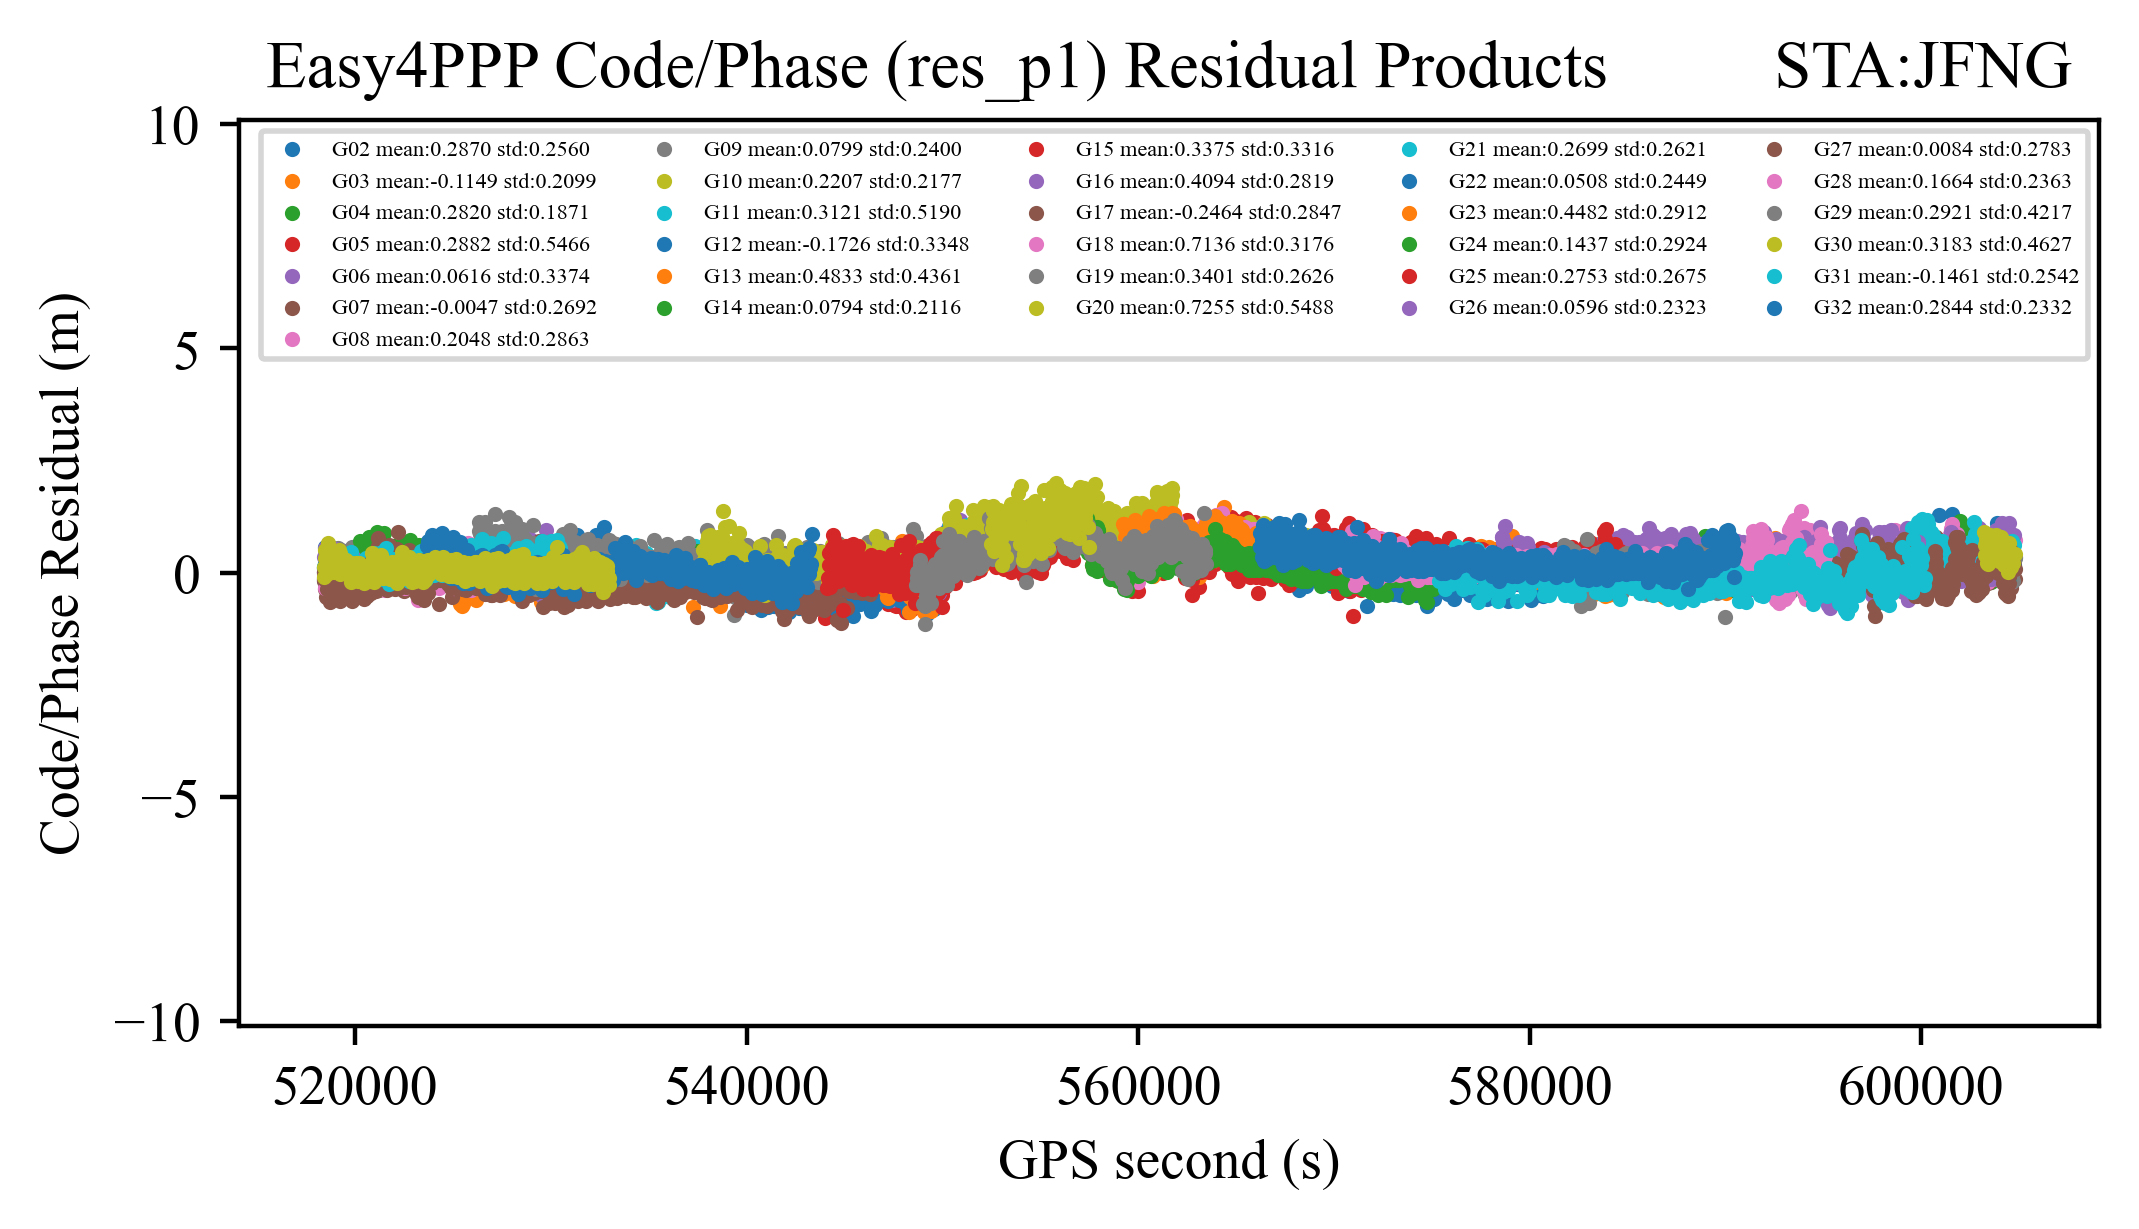

In [7]:
#绘图: 定位残差(NLOS误差)
import matplotlib.pyplot as plt

sys_name='G'        #系统标识符选择: G: GPS; C: BDS
sys_sat_num=65      #系统PRN码最大值: 此选项可限制绘图卫星的最大PRN范围
target='res_p1'     #残差归属: res_p1: 第一频率伪距; res_p2: 第二频率伪距; res_l1: 第一频率载波相位; res_l2: 第二频率载波相位
ylim=[-10.1,10.1]   #图像纵轴范围, 若空, 则由matplotlib自适应

target_prns=[]
legend=[]
plt.figure(dpi=400,facecolor="white",figsize=(6,3))
for PRN in range(1,sys_sat_num+1):
    PRN=sys_name+"{:02d}".format(PRN)
    stec_list=[]
    for out in sol_log:
        if(len(target_prns)==0):
            prns=list(out.keys())
        else:
            prns=target_prns.copy()
        if(PRN in prns and PRN in list(out.keys())):
                if(target in list(out[PRN].keys())):
                #print(PRN,list(out[PRN].keys()))
                    GPSsec=out[PRN]['GPSsec']
                    stec_list.append([GPSsec,out[PRN][target]])
    #print(stec_list)
    
    if(len(stec_list)):
        plt.scatter(np.array(stec_list)[:,0],np.array(stec_list)[:,1],s=3)
        legend.append(PRN+' mean:{:.4f} std:{:.4f}'.format(np.mean(np.array(stec_list)[:,1]), np.std(np.array(stec_list)[:,1]) ) )
        #np.save('resp1_G07.npy',stec_list)

if(ylim!=[]):
    plt.ylim(ylim[0],ylim[1])

plt.ylabel("Code/Phase Residual (m)")
plt.xlabel("GPS second (s)")
plt.title("Easy4PPP Code/Phase ({}) Residual Products          STA:{}".format(target,STA_name))
plt.legend(legend,ncol=5,fontsize=4)

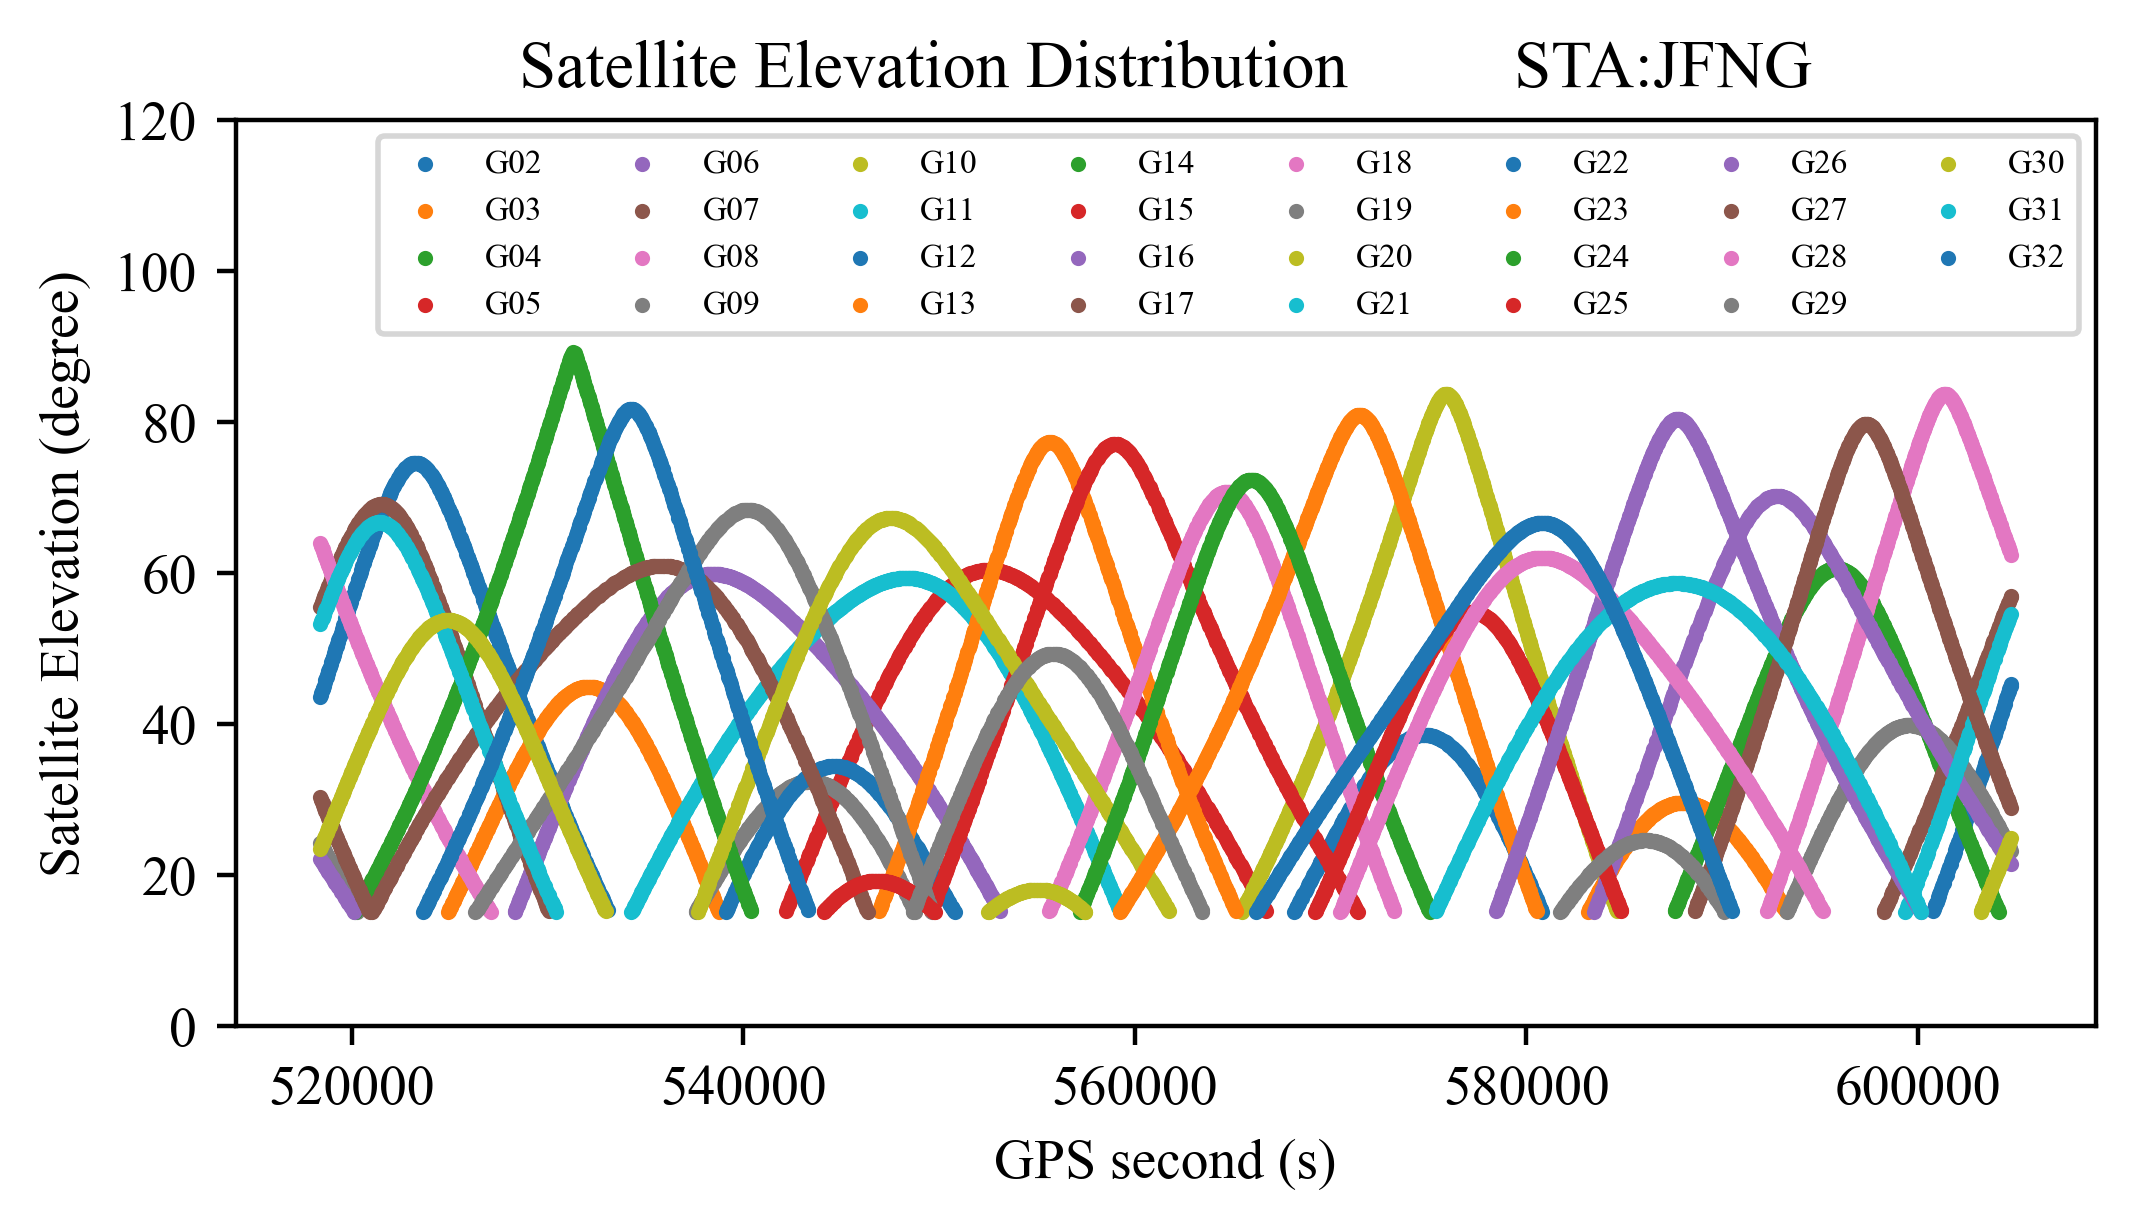

In [8]:
#卫星天顶图
import matplotlib.pyplot as plt

sys_name='G'        #系统标识符选择: G: GPS; C: BDS
sys_sat_num=65      #系统PRN码最大值: 此选项可限制绘图卫星的最大PRN范围
target='azel'       #对象归属: 方位角高度角azel
ylim=[0,120]        #图像纵轴范围, 若空, 则由matplotlib自适应

target_prns=[]
legend=[]
plt.figure(dpi=400,facecolor="white",figsize=(6,3))
for PRN in range(1,sys_sat_num+1):
    PRN=sys_name+"{:02d}".format(PRN)
    tag_list=[]
    for out in sol_log:
        if(len(target_prns)==0):
            prns=list(out.keys())
        else:
            prns=target_prns.copy()
        if(PRN in prns and PRN in list(out.keys())):
                if(target in list(out[PRN].keys())):
                #print(PRN,list(out[PRN].keys()))
                    GPSsec=out[PRN]['GPSsec']
                    tag_list.append([GPSsec,out[PRN][target][1]])
    
    if(len(tag_list)):
        plt.scatter(np.array(tag_list)[:,0],np.array(tag_list)[:,1],s=3)
        legend.append(PRN)
        #np.save('resp1_G07.npy',stec_list)

if(ylim!=[]):
    plt.ylim(ylim[0],ylim[1])

plt.ylabel("Satellite Elevation (degree)")
plt.xlabel("GPS second (s)")
plt.title("Satellite Elevation Distribution          STA:{}".format(STA_name))
plt.legend(legend,ncol=8,fontsize=6)